![bannner](../../../src/visuals/banner.png)

# Deep Learning for Sequences

It is finally time to change our data type! Up till now we have explored a lot of the PyTorch methods specifically for Images. This means that we have some static data and are trying to make some downstream prediction of it. What this method was missing was any temporal or sequence dimension where a specific datapoint in time has some relations to times before and after it.

We have all types of sequences in the real world!

- Natural Langauge is a Sequence of Words
- Speech is a Sequence of Signals at varying amplitudes
- Stock Market is a Sequence of Price data
- Videos are a Sequence of Images

The ability to be able to model this is crucial! Here are few of the options we have currently:

- **Convolution!** Instead of iterating through a 2D image, we would just slide a filter across a 1D vector of values. Otherwise this is the same as everything we did with Vision. Unfortunately, Convolutions don't have any mechanism to model relationships between tokens that are further apart than the filter size. Therefore, if we have a kernel of size 7 and a sentence with 30 words, we couldn't related how the last words are related to the first words.

- **Recurrent Neural Network:** RNN can model sequence data and use a concept called "Backpropagation Through Time" to be able to relate different parts of a sequence. We will explore backprop through time a little later, but the main problem with RNN models is it can only successfully relate short sequences as it doesn't have the "memory" to remember things far back in time.

- **Long Short Term Memory:** A popular variant of the RNN that incorporates additional logic to enable remembering things further back in time!

- **Transformers:** The most popular and powerful sequence model today due to a lot of great properties! We will go into depth on the Transformer Architecture in a future lesson!


## Recurrent Neural Network

Lets first take a look at the RNN Architecture!

![RNN](../../../src/visuals/rnn_rolled_unrolled.png)

[credit](https://www.analyticsvidhya.com/blog/2022/03/a-brief-overview-of-recurrent-neural-networks-rnn/)

On the left side we see clearly how the RNN works. We pass in the first part of the input X through some hidden state and some weight matrix W will map it to an output. We then grab the next part of the sequence for X, reuse the updated hidden state from before and again remap to another output for the next timestep. This process is repeated until the sequence is complete. On the right, we see this process flattened out, and this is known as the **Unrolled View** of the RNN. 


Here is a visual that shows you how it all fits together!
![rnngif](../../../src/visuals/Fully_connected_Recurrent_Neural_Network.gif)
[credit](https://www.simplilearn.com/tutorials/deep-learning-tutorial/rnn)


Now in these examples, we see that we have only a single layer of an RNN, but you can theoretically have as many as you want! Here is a visual of this that really helped me piece all this together. **Do note that this image below is actually of an LSTM which has one crucial difference from RNN!**

![Unfolded LSTM](../../../src/visuals/unfolded_multilayer_lstm.png)

[credit](https://stackoverflow.com/questions/48302810/whats-the-difference-between-hidden-and-output-in-pytorch-lstm)

Here are the main ideas to takeaway from the image above!
- We start with some $h_0$ and $c_0$ known as the hidden and cell states. 
    - RNN and LSTM both have a Hidden State that acts as the "working memory" for the model. This typically cannot model long sequences very well on its own.
    - The Cell State is unique to the LSTM and acts as the long term memory for the model to remember attributes of the sequence far back in time. 
    
- The **depth** shows the number of LSTM/RNN layers we want and **t** is the number of timesteps we have in our data

- The output gives us the "hidden states" of every value in the timeseries from the last LSTM/RNN layer which can be passed to another LSTM/RNN if we wanted. On the right, we can get the final hidden state/cell state for all layers that can be used for prediction (potentially, it depends on what we want). 

    - To clarify, the output gives all hidden states from $h_1, h_2, ... h_n$ where on the right, we get only $h_n$ as well as $c_n$ if it is an LSTM model. 
    
    
## RNN vs LSTM

Going in depth into the architectural differences of RNN vs LSTM and how "long term memory" is encoded is a bit tough to explain but let me first offer some intuition. RNN suffer a condition that we talked about when going through ResNets: **Vanishing Gradients**. The reason this happens is the way these sequence models optimize through a technique known as backpropagation through time. 


#### Backpropagation Through Time 
First think back to the Rolled version of the RNN module, at every iteration we are passing in a single timepoint through some learnable parameters, but the underlying weights to optimize are the same. (i.e You can have a sequence as long as you want but  the model will be the same size, saving on computation). This means the same set of weights will need to be optimized and we are encoding the change in sequence by updating the hidden state that hopefully aggregates previous information. Therefore if we have inputs $x_1, x_2, ... x_n$, we will pass in a value at a time, update the hidden state, and output a value. Afterwards we will calculate a loss depending on what our task was (classification, regression, etc...) and then we will perform the chain rule and backpropagate through every time an input was passed to our weights. If we had $N$ inputs in our sequence, then we will have $N$ things to multiply together in our gradients

It seems like a weird idea but it will make more sense with the visual:

![backpropthroughtime](../../../src/visuals/backpropthroughtime.png)

[credit](https://dennybritz.com/posts/wildml/recurrent-neural-networks-tutorial-part-3/)

You can clearly see that to get back to updating at time $x_0$, we need to backpropagate through all the times after it! So the derivative of $E_3$, the output for our RNN at timestep 3, with respect to the weights in $S_0$ will be as such:

$$\frac{dE_3}{ds_0} =\frac{dE_3}{ds_3}\frac{ds_3}{ds_2}\frac{ds_2}{ds_1}\frac{ds_1}{ds_0}$$


Therefore, if our sequence gets longer and the gradients are small, we will have the same issue that ResNet tried to solve with Vanishing Gradients! 


![image.png](../../../src/visuals/rnn-vs-lstm.png)

[credit](https://ashutoshtripathi.com/2021/07/02/what-is-the-main-difference-between-rnn-and-lstm-nlp-rnn-vs-lstm/)

As we compare our LSTM and RNN architecture, we can see that the LSTM has much more going on but there are a few important ways it avoids the "forgetfullness" of RNN.
 - **Forget Gate:** Decides what past information is important and what to remove. This is then passed through a sigmoid where values close to 0 would cause it to forget, and values close to 1 are to keep
 - **Input Gate:** A calculation to figure out how much of the input values from $x_t$ (the current timestep value) and $h_{t-1}$ (the hidden state from the previous timestep) should be encoded into the cell state. Essentially, how important is the current timestep and should we add it to our long term memory. Again it uses a sigmoid to scale between 0 and 1.
- **Output Gate:** Calculation of what the next hidden state should be for the next timestep. 


The Cell State does a simple sum with the output of our Forget and Input Gates and then moves on to the next timestep! Essentially, during backpropagation, this pathway created by the cell state offers a new path for backpropagation that circumvents all the messy calculations happening in the gates, greatly reducing the vanishing gradient problem in a similar way we dealt with ResNet!


## What Kinds of Problems can we Solve with Sequence Models?

![mapping](../../../src/visuals/rnn_input_output_setups.png)

[credit](https://wandb.ai/ayush-thakur/dl-question-bank/reports/LSTM-RNN-in-Keras-Examples-of-One-to-Many-Many-to-One-Many-to-Many---VmlldzoyMDIzOTM)

- One to One is what we have been doing up till now: Given a single image what is a prediction
- One to Many: Given a vector of Image Features can we generate a text caption
- Many to One: Can we classify a sequence?
- Many to Many: This can be two things
    - If Input/Output are not aligned, this would be used for Language Translation where we input a sequence and output a sequence
    - If Input/Output are aligned, then this can be Video Classification where we want to classify each frame but use the information in previous frames
    
    
## Lets Start Putting it Together!

Theres going to be a couple of new ideas here but we will get through it step by step! In our [PyTorch Dataloader](https://github.com/priyammaz/PyTorch-Adventures/tree/main/PyTorch%20Basics/PyTorch%20DataLoaders) we made a character level DataLoader, and we talked about how there are other options, but again, to keep it simple, lets do a word level model. We will just split our datatset by words and then remove the least occuring words!

In [1]:
import numpy as np
import os
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import re

import nltk
# nltk.download('stopwords') #Download the NLTK Stopwords
from nltk.corpus import stopwords
stopwords = set(stopwords.words("english"))

## Lets Take a Peek at the Dataset Again

We want to find out what words we want to keep, how we want to split it, and just a general analysis!

In [2]:
### Load Path to Files ###
path_to_data = "../../../data/aclImdb/train"

path_to_pos_fld = os.path.join(path_to_data, "pos")
path_to_neg_fld = os.path.join(path_to_data, "neg")

path_to_pos_txt = [os.path.join(path_to_pos_fld, file) for file in os.listdir(path_to_pos_fld)]
path_to_neg_txt = [os.path.join(path_to_neg_fld, file) for file in os.listdir(path_to_neg_fld)]

training_files = path_to_pos_txt + path_to_neg_txt


### Easy Text Analysis ###
alltxt = []
len_words = []
for file in training_files:
    with open(file, "r") as f:
        text = f.readlines()[0].lower() # Convert to LowerCase
        text = re.sub(r'[^\w\s]', '', text) # Remove All Punctuation
        text = text.split(" ") # Split by Space
        text = [word for word in text if (word not in stopwords) and (len(word) > 0)] # Remove all stopwords and empty strings
        len_words.append(len(text))
        alltxt += text
    
print("Average Sentence Length", np.mean(len_words))

### GET COUNT OF UNIQUE WORDS ###
unique_counts = dict(Counter(alltxt))
words = sorted([key for (key,value) in unique_counts.items() if value > 500])

words.append("<UNK>")
words.append("<PAD>")

word2idx = {c:i for i,c, in enumerate(words)}
idx2char = {i:c for i,c in enumerate(words)}

Average Sentence Length 124.19728


### Build IMDB Dataset

We want to follow the same preprocessing steps we did above to make sure its accurate. We will fill words that are not in our tokenizer with Unknown tokens. This will follow our

In [3]:
class IMDBDataset(Dataset):
    def __init__(self, path_to_data, word2idx, max_seq_len=200):
        path_to_pos_fld = os.path.join(path_to_data, "pos")
        path_to_neg_fld = os.path.join(path_to_data, "neg")

        path_to_pos_txt = [os.path.join(path_to_pos_fld, file) for file in os.listdir(path_to_pos_fld)]
        path_to_neg_txt = [os.path.join(path_to_neg_fld, file) for file in os.listdir(path_to_neg_fld)]

        self.training_files = path_to_pos_txt + path_to_neg_txt
        self.tokenizer = word2idx
        self.max_len = max_seq_len
        
    def __len__(self):
        return len(self.training_files)
    
    def __getitem__(self, idx):
        path_to_txt = self.training_files[idx]
        
        ### PREP TEXT ###
        with open(path_to_txt, "r") as f:
            txt = f.readlines()[0].lower()
        text = re.sub(r'[^\w\s]', '', txt) 
        text = text.split(" ") 
        text = [word for word in text if (word not in stopwords) and (len(word) > 0)]
        
        tokenized = []
        for word in text:
            if word in self.tokenizer.keys():
                tokenized.append(self.tokenizer[word])
            else:
                tokenized.append(self.tokenizer["<UNK>"])
                
        sample = torch.tensor(tokenized)
        
        if len(sample) > self.max_len:
            diff = len(sample) - self.max_len
            start_idx = np.random.randint(diff)
            sample = sample[start_idx:start_idx+self.max_len]

        ### GRAB CLASS LABEL ###
        if "neg" in path_to_txt:
            label = 0
        else:
            label = 1
            
        return sample, label
        
                
imdbdataset = IMDBDataset(path_to_data, word2idx)

### Check Dataset Works ###
counter = 0
for data, label in imdbdataset:
    print(data.shape)
    print(label)
    break
    

### Write Custom Collator ###
def data_collator(batch):
    texts, labels = [], []
    
    for text, label in batch:
        labels.append(label)
        texts.append(text)
        
    labels = torch.tensor(labels)
    
    ### Pad the list of sequences and then convert to tensor like example above but with our padding token <PAD> ###
    texts = nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=word2idx["<PAD>"])
    return texts, labels   


imdbloader = DataLoader(imdbdataset, batch_size=16, shuffle=True, collate_fn=data_collator)

counter = 0
for text, label in imdbloader:
    print(text)
    print(label)
    break

torch.Size([72])
1
tensor([[989, 740, 989,  ..., 962, 989, 989],
        [686, 989, 359,  ..., 990, 990, 990],
        [989, 989, 989,  ..., 990, 990, 990],
        ...,
        [989, 989, 989,  ..., 927, 989, 989],
        [120, 897, 521,  ..., 990, 990, 990],
        [924, 462, 681,  ..., 990, 990, 990]])
tensor([1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0])


Our Dataset has now been converted to a series of numbers, but we still have a small issue. These numbers don't really mean anything... We just randomly assigned some integer value to each of these words but that doesn't mean they can express the meaning of the word. Therefore we have to use something called an Embedding!

### Embedding 
Embeddings are numerical representation of some concept. In our case specifically, we want to represent a specific word with a vector of lenght 256 (arbritrary value that I picked, you can use much larger embedding dimensions). Our goal during the training process is to have words that are similar in meaning to have vectors that are closer together in the high dimensional space. For example, we want words like, Bad, Horrible, and Terrible to be closer together but far apart from words like Good, Amazing, Incredible. To do this we can use something known as a PyTorch Embedding!

The embedding we want will have a row for each unique word in our corpus (along with unknown and padding) and the width will be our embedding dimension. This will be a simple lookup table, where if we want the embedding that goes with the word labeled with the index 3, then we grab the 3rd row of the embedding table. Lets try this!

In [4]:
emb = nn.Embedding(5,3)

print("Embedding Weights")
print(emb.weight)

print("Embedding for Single Sentence")
sentence = torch.tensor([1, 3]) # Sentence words as a list of numbers
print(emb(sentence))
print(emb(sentence).shape)

print("Embedding for Batch Sentence")
batch_sentences = torch.tensor([[1,3], [1,3], [1,3]])
print(emb(batch_sentences))
print(emb(batch_sentences).shape)

Embedding Weights
Parameter containing:
tensor([[-0.6442, -0.2410, -1.9718],
        [ 0.7162,  0.7912, -0.1021],
        [-1.1143,  0.3708,  0.7800],
        [ 0.2467,  0.2802,  1.0522],
        [ 0.7855,  0.4135, -1.8277]], requires_grad=True)
Embedding for Single Sentence
tensor([[ 0.7162,  0.7912, -0.1021],
        [ 0.2467,  0.2802,  1.0522]], grad_fn=<EmbeddingBackward0>)
torch.Size([2, 3])
Embedding for Batch Sentence
tensor([[[ 0.7162,  0.7912, -0.1021],
         [ 0.2467,  0.2802,  1.0522]],

        [[ 0.7162,  0.7912, -0.1021],
         [ 0.2467,  0.2802,  1.0522]],

        [[ 0.7162,  0.7912, -0.1021],
         [ 0.2467,  0.2802,  1.0522]]], grad_fn=<EmbeddingBackward0>)
torch.Size([3, 2, 3])


Also note that the weights of our embeddings have a requires_grad is True. That means this weight matrix will be updated via gradient descent over time to hopefully give more meaningful embeddings for each word. 

### Explore the LSTM Module

```
nn.LSTM(input_size,  # Expected number of features per input (in our case it will be the embedding depth)
        hidden_size, # Number of features in Hidden State
        num_layers,  # Number of LSTM Cells we want to stack
        batch_first, # Will our tensor have batch dimension or sequence dimension first
)
```
#### Inputs to the LSTM
- $H_0$: Num Layers x batch_size x Hidden Size -> Initialized as 0 if no information given
- $C_0$: Num Layers x batch_size x Hidden Size -> Initialized as 0 if no information given

In [5]:
batch_size = 5        # How Many Samples
sequence_length = 15  # Sequence Length Per Sample
input_size = 10       # Dimension of vector for each timestep in sequence per sample      
hidden_size = 20      # Dimension expansion from Input size Inside the LSTM cell
num_layers = 2        # Number of LSTM Cells


lstm = nn.LSTM(input_size=input_size,
               hidden_size=hidden_size, 
               num_layers=num_layers,
               batch_first=True)



rand = torch.rand(batch_size, sequence_length, input_size) # Batch x sequence length x input_size
h0 = torch.zeros(num_layers, batch_size, hidden_size)      # Num Layers x Batch Size x Hidden State
c0 = torch.zeros(num_layers, batch_size, hidden_size)      # Num Layers x Batch Size x Hidden State


output, (hn, cn) = lstm(rand, (h0, c0))

print("Output:", output.shape) # Returns Batch Size x Sequence Length x Hidden Size -> Hidden state for each timestep
print("Final H:", hn.shape)    # Returns Num Layers x Batch Size x Hidden Size -> Last Hidden state for every layer
print("Final c:", cn.shape)    # Returns Num Layers x Batch Size x Hidden Size -> Last Hidden state for every layer


hn[-1][0] == output[0][-1] # Check if the Last layer, first sample of Hn has same hidden size as first sample, last timestep of output

Output: torch.Size([5, 15, 20])
Final H: torch.Size([2, 5, 20])
Final c: torch.Size([2, 5, 20])


tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True])

### We Can Now Build the Model!
Our model essentially will take in a batch of indexes that reference a word in our tokenzier which we will use to grab the cooresponding vector from our embedding matrix. This will then be passed to an LSTM module. Becuase we only care about a single prediction (**Many to One**) we will only use the last part of the output and then a linear layer to map to our two Positive/Negative classes.

In [6]:
class LSTMNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, num_classes, device):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.device = device
        
        ### Define Embedding Matrix ###
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        
        ### Define LSTM ###
        self.lstm = nn.LSTM(input_size=self.embedding_dim,
                            hidden_size=self.hidden_size, 
                            num_layers=self.num_layers,
                            batch_first=True)
        
        ### Final Classifier Layers ###
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(self.hidden_size, self.num_classes)
        
    def forward(self, x):
        batch_size, sequence_len = x.shape
        embeddings = self.embedding(x) # (Batch x Sequence Len x Embedding Dim)
        
        ### INITIALIZE HIDDEN AND CELL STATE AS 0 ###
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)  # Num Layers x Batch Size x Hidden State
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)  # Num Layers x Batch Size x Hidden State
        
        ### PASS THROUGH LSTM BLOCK ###
        output, (hn, cn) = self.lstm(embeddings, (h0,c0)) 
        
        # Output -> [batch x seqlen x hidden]
        # Hn -> [num_layers x batch x hidden]
        # Cn -> [num_layers x batch x hidden]
        
        ### CUT OFF LAST HIDDEN STATE FOR EVERY BATCH ###
        last_hidden  = output[:, -1, :] # Batch Size x Hidden
        
        out = self.dropout(last_hidden)
        out = self.fc(out)
        
        return out

### Train Model!!

In [7]:
### Build Training and Testing Dataset ###
train_dataset = IMDBDataset("../../../data/aclImdb/train", word2idx)
test_dataset = IMDBDataset("../../../data/aclImdb/test", word2idx)

In [8]:
### SELECT DEVICE ###
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on Device {DEVICE}")

### LOAD IN and Modify AlexNet Model ###
model = LSTMNet(vocab_size=len(word2idx),
                embedding_dim=128,
                hidden_size=256, 
                num_layers=1, 
                num_classes=2, 
                device=DEVICE)

model = model.to(DEVICE)

### MODEL TRAINING INPUTS ###
epochs = 15
optimizer = optim.Adam(params=model.parameters(), lr=0.0005)
loss_fn = nn.CrossEntropyLoss()
batch_size = 128

trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=data_collator)
valloader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=data_collator)

def train(model, device, epochs, optimizer, loss_fn, batch_size, trainloader, valloader):
    log_training = {"epoch": [],
                    "training_loss": [],
                    "training_acc": [],
                    "validation_loss": [],
                    "validation_acc": []}

    for epoch in range(1, epochs + 1):
        print(f"Starting Epoch {epoch}")
        training_losses, training_accuracies = [], []
        validation_losses, validation_accuracies = [], []
        
        model.train() # Turn On BatchNorm and Dropout
        for image, label in tqdm(trainloader):
            image, label = image.to(DEVICE), label.to(DEVICE)
            optimizer.zero_grad()
            out = model.forward(image)
        
            ### CALCULATE LOSS ##
            loss = loss_fn(out, label)
            training_losses.append(loss.item())

            ### CALCULATE ACCURACY ###
            predictions = torch.argmax(out, axis=1)
            accuracy = (predictions == label).sum() / len(predictions)
            training_accuracies.append(accuracy.item())

            loss.backward()
            
            ### Just Incase of Exploding Gradients
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()

        model.eval() # Turn Off Batchnorm 
        for image, label in tqdm(valloader):
            image, label = image.to(DEVICE), label.to(DEVICE)
            with torch.no_grad():
                out = model.forward(image)

                ### CALCULATE LOSS ##
                loss = loss_fn(out, label)
                validation_losses.append(loss.item())

                ### CALCULATE ACCURACY ###
                predictions = torch.argmax(out, axis=1)
                accuracy = (predictions == label).sum() / len(predictions)
                validation_accuracies.append(accuracy.item())

        training_loss_mean, training_acc_mean = np.mean(training_losses), np.mean(training_accuracies)
        valid_loss_mean, valid_acc_mean = np.mean(validation_losses), np.mean(validation_accuracies)

        log_training["epoch"].append(epoch)
        log_training["training_loss"].append(training_loss_mean)
        log_training["training_acc"].append(training_acc_mean)
        log_training["validation_loss"].append(valid_loss_mean)
        log_training["validation_acc"].append(valid_acc_mean)

        print("Training Loss:", training_loss_mean) 
        print("Training Acc:", training_acc_mean)
        print("Validation Loss:", valid_loss_mean)
        print("Validation Acc:", valid_acc_mean)
        
    return log_training, model


training_logging, model = train(model=model,
                                device=DEVICE,
                                epochs=epochs,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                batch_size=batch_size,
                                trainloader=trainloader,
                                valloader=valloader)

Training on Device cuda
Starting Epoch 1


100%|█████████████████████████████████████████████████████████████| 196/196 [00:05<00:00, 36.01it/s]


Training Loss: 0.6944948833207695
Training Acc: 0.510124362244898
Validation Loss: 0.693415641784668
Validation Acc: 0.5003029336886746
Starting Epoch 2


100%|█████████████████████████████████████████████████████████████| 196/196 [00:04<00:00, 44.99it/s]


Training Loss: 0.6931986544205218
Training Acc: 0.5089923470300071
Validation Loss: 0.6922745397504495
Validation Acc: 0.510499043428168
Starting Epoch 3


100%|█████████████████████████████████████████████████████████████| 196/196 [00:04<00:00, 47.60it/s]


Training Loss: 0.6924609252992941
Training Acc: 0.5101084184585786
Validation Loss: 0.692766573052017
Validation Acc: 0.5073660715502135
Starting Epoch 4


100%|█████████████████████████████████████████████████████████████| 196/196 [00:04<00:00, 47.76it/s]


Training Loss: 0.69017094829861
Training Acc: 0.5184072066022425
Validation Loss: 0.6941802991288049
Validation Acc: 0.5089524871840769
Starting Epoch 5


100%|█████████████████████████████████████████████████████████████| 196/196 [00:04<00:00, 47.80it/s]


Training Loss: 0.6869278197385826
Training Acc: 0.5197066327138823
Validation Loss: 0.6803608050151747
Validation Acc: 0.53162468118327
Starting Epoch 6


100%|█████████████████████████████████████████████████████████████| 196/196 [00:03<00:00, 49.04it/s]


Training Loss: 0.684677395893603
Training Acc: 0.5258370537538918
Validation Loss: 0.6831890758203001
Validation Acc: 0.5269610969995966
Starting Epoch 7


100%|█████████████████████████████████████████████████████████████| 196/196 [00:04<00:00, 46.78it/s]


Training Loss: 0.6920951793388445
Training Acc: 0.5119100766522544
Validation Loss: 0.6919770940225951
Validation Acc: 0.513313137755102
Starting Epoch 8


100%|█████████████████████████████████████████████████████████████| 196/196 [00:04<00:00, 48.07it/s]


Training Loss: 0.6901122781695151
Training Acc: 0.5149154976314428
Validation Loss: 0.6911368841419414
Validation Acc: 0.513671875
Starting Epoch 9


100%|█████████████████████████████████████████████████████████████| 196/196 [00:04<00:00, 48.06it/s]


Training Loss: 0.6896594537764179
Training Acc: 0.5155133930396061
Validation Loss: 0.6868969189877413
Validation Acc: 0.5243861608359278
Starting Epoch 10


100%|█████████████████████████████████████████████████████████████| 196/196 [00:03<00:00, 49.67it/s]


Training Loss: 0.6829774814600847
Training Acc: 0.5244339923469388
Validation Loss: 0.6733035661128103
Validation Acc: 0.5388632015306123
Starting Epoch 11


100%|█████████████████████████████████████████████████████████████| 196/196 [00:04<00:00, 48.66it/s]


Training Loss: 0.6034251408917564
Training Acc: 0.6758529975706217
Validation Loss: 0.5499327061127643
Validation Acc: 0.7206951531828666
Starting Epoch 12


100%|█████████████████████████████████████████████████████████████| 196/196 [00:04<00:00, 44.54it/s]


Training Loss: 0.46741062722035814
Training Acc: 0.7900988520408163
Validation Loss: 0.43070661671915833
Validation Acc: 0.8073580994897959
Starting Epoch 13


100%|█████████████████████████████████████████████████████████████| 196/196 [00:04<00:00, 45.59it/s]


Training Loss: 0.3938639296256766
Training Acc: 0.8306919643465354
Validation Loss: 0.3856878314091235
Validation Acc: 0.8331951532436876
Starting Epoch 14


100%|█████████████████████████████████████████████████████████████| 196/196 [00:03<00:00, 51.08it/s]


Training Loss: 0.3702607441465465
Training Acc: 0.8423309949587803
Validation Loss: 0.36279534137978847
Validation Acc: 0.8390704718779545
Starting Epoch 15


100%|█████████████████████████████████████████████████████████████| 196/196 [00:04<00:00, 45.26it/s]

Training Loss: 0.34477025620183166
Training Acc: 0.8526227677963218
Validation Loss: 0.35282590513934897
Validation Acc: 0.8443718111636688


### Something to Keep in Mind for LSTMs

I have seen this time to time when training an LSTM, and it mainly has to do with the Loss Curve not decreasing at all for a few iterations. Just keep this in mind when training and don't see an improvements, maybe you just have to train longer until it start decreasing pretty quickly!

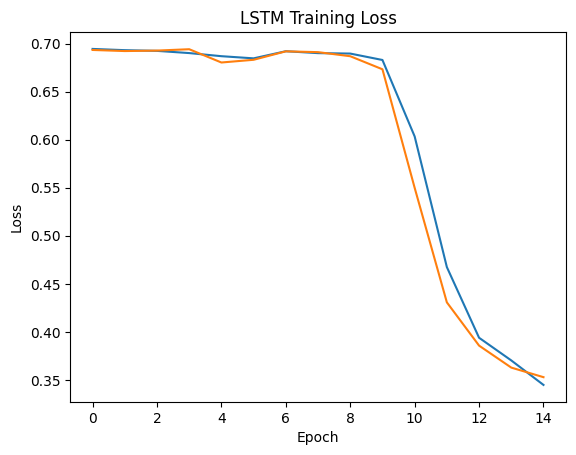

In [9]:
plt.plot(training_logging["training_loss"])
plt.plot(training_logging["validation_loss"])
plt.title("LSTM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Limitations of the LSTM/RNN Architecture

The main downfall of this method is the training time on long sequences. For us to pass the 100th token of a sequence into our model, we first need to pass in the previous 99. This means that the entire architecture has no way to be parallelized and is inherently slow. Regardless, it is a crucial prerequisite you need to understand before we start to tackle Transformers in the future that solve many of these issues!!

That brings to an end our introduction to Sequence Classification! There is definitely a lot of moving parts here, and although the LSTM internaly is extremely complex, using these tools isnt too bad! Now that we have completed our **Many to One** model, in the next lesson we will do a **Many to Many** model for character level Harry Potter Generation!